In [1]:
%run "Funciones_Prepara_Prediccion.ipynb"
%run "../1. Librerias Mongo/MongoDB_Connections.ipynb"
%run "../1. Librerias Mongo/MongoDB_Funciones_Consultas.ipynb"

import pandas as pd
import numpy as np
import joblib
import time

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Datos base sólo para obtener parámetros: TEMPORADA, DESC_TIEMPO y ESTACIONES
datos = _dataBaseOriginal("../../Data/DataFrame_Final_Cierre_Cluster_2017_2019.csv")

In [3]:
datos

,ESTACION,ANIO,MES,DIA,TEMPORADA,DIA_SEMANA,Es_Festivo,Es_FinSemana,DEMANDA,TEMP_MAX,TEMP_MIN,HUMEDAD,VIENTO,PRESION,PRECIPITACION_1h,PRECIPITACION_3h,DESC_TIEMPO
0,1,2017,3,31,INVIERNO,6,0,0,7,12.58,12.58,44.000000,7.720000,1020.000000,0.0,0.0,Clouds
1,1,2017,4,1,PRIMAVERA,7,0,1,61,16.12,9.63,40.611111,6.958889,1020.666667,0.0,0.0,Clouds
2,1,2017,4,2,PRIMAVERA,1,0,1,58,17.92,4.92,45.476190,2.606667,1021.095238,0.0,0.0,Clear
3,1,2017,4,3,PRIMAVERA,2,0,0,77,18.92,3.58,42.190476,1.874762,1022.904762,0.0,0.0,Clear
4,1,2017,4,4,PRIMAVERA,3,0,0,85,22.03,2.58,37.904762,2.535714,1022.333333,0.0,0.0,Clear
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176472,175,2020,2,25,INVIERNO,3,0,0,87,17.48,5.91,54.769231,6.007692,1018.307692,0.0,0.0,Clouds
176473,175,2020,2,26,INVIERNO,4,0,0,158,15.18,6.22,48.600000,5.321000,1020.500000,0.0,0.0,Clear
176474,175,2020,2,27,INVIERNO,5,0,0,173,18.41,6.35,49.095238,6.207143,1020.619048,0.0,0.0,Clear
176475,175,2020,2,28,INVIERNO,6,0,0,166,18.38,5.74,49.428571,2.174762,1019.571429,0.0,0.0,Clear


In [4]:
db_Meteo = _connect_mongo('cloud', 'cluster0.15npsxw.mongodb.net', None, 'ucmtfm2022', 'UCM_2022', 'BiciMAD', 
                          'Meteo_US_NivelHora')
data_Meteo = _baseMeteorologia(db_Meteo)

Conexion OK
Collection(Database(MongoClient(host=['ac-x1d17w2-shard-00-01.15npsxw.mongodb.net:27017', 'ac-x1d17w2-shard-00-00.15npsxw.mongodb.net:27017', 'ac-x1d17w2-shard-00-02.15npsxw.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin', replicaset='atlas-xyv6ql-shard-0', tls=True, serverselectiontimeoutms=4000, tlscafile='C:\\ProgramData\\Anaconda3\\lib\\site-packages\\certifi\\cacert.pem'), 'BiciMAD'), 'Meteo_US_NivelHora')


In [5]:
data_festivos = _baseFestivos()

In [6]:
df_estaciones = datos.ESTACION.unique()
# df_estaciones = df_estaciones[:3]
df_estaciones

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  69,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
        95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
       173, 174, 175], dtype=int64)

In [7]:
# Generación de datos para Dummies

# dataDummy = _agregaRegistrosParaDummies(datos.TEMPORADA.unique(), datos.DESC_TIEMPO.unique())

dataDummy = _dataBaseOriginalNula("../../Data/DataFrame_Final_Cierre_Cluster_2017_2019.csv")

cat_cols= ['MES', 'DIA_SEMANA', 'TEMPORADA', 'Es_Festivo', 'Es_FinSemana','DESC_TIEMPO']
num_cols= ['TEMP_MAX','TEMP_MIN','HUMEDAD','VIENTO','PRESION']

In [8]:
%run "Funciones_Prepara_Prediccion.ipynb"

fecha_inicio = pd.to_datetime('01/12/2020', format='%d/%m/%Y')
fecha_termino = fecha_inicio + pd.DateOffset(30)

# predsDiarias = pd.DataFrame(columns=['ESTACION', 'FECHA', 'PREDICCION'])

t_ini = time.time()
# df_estaciones = [1]

for estacion in df_estaciones:
    
    print(estacion)

    model = joblib.load('../Modelos/Modelo_'+ str(estacion) +'.pkl')
    
    for fecha in pd.date_range(start=fecha_inicio, end=fecha_termino):
        FechaAPredecir = _estacionDataFechaNueva(estacion, fecha, data_Meteo, data_festivos, dataDummy, cat_cols, num_cols)

        # Prediccion según modelo(estacion)
        prediccion = round(model.predict(FechaAPredecir)[0])
        prediccion = pd.DataFrame([str(estacion), fecha.year, fecha.month, fecha.day, prediccion]).T
        
        # Se crea predsFechas sólo en primera ejecución de los loops
        if ((fecha==fecha_inicio) & (estacion==df_estaciones[0])):
            print('ini')
            Fechas = FechaAPredecir.copy()
            Predicciones = prediccion.copy()
        else:
            Fechas = pd.concat([Fechas, FechaAPredecir])
            Predicciones = pd.concat([Predicciones, prediccion])
        
t_end = time.time()
print ((t_end - t_ini)/60)

Predicciones.rename(columns={0:'ESTACION', 1:'ANIO', 2:'MES', 3:'DIA', 4:'PREDICCION'}, inplace=True)
Predicciones['ESTACION']=Predicciones['ESTACION'].astype(int)
Predicciones['ANIO']=Predicciones['ANIO'].astype(int)
Predicciones['MES']=Predicciones['MES'].astype(int)
Predicciones['DIA']=Predicciones['DIA'].astype(int)
Predicciones['PREDICCION']=Predicciones['PREDICCION'].astype(int)


1
ini
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
69
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
11.784190189838409


In [9]:
Predicciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5332 entries, 0 to 0
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   ESTACION    5332 non-null   int32
 1   ANIO        5332 non-null   int32
 2   MES         5332 non-null   int32
 3   DIA         5332 non-null   int32
 4   PREDICCION  5332 non-null   int32
dtypes: int32(5)
memory usage: 145.8 KB


In [10]:
Predicciones

,ESTACION,ANIO,MES,DIA,PREDICCION
0,1,2020,12,1,71
0,1,2020,12,2,67
0,1,2020,12,3,66
0,1,2020,12,4,51
0,1,2020,12,5,58
...,...,...,...,...,...
0,175,2020,12,27,83
0,175,2020,12,28,106
0,175,2020,12,29,107
0,175,2020,12,30,112


In [11]:
Predicciones.to_csv('../../data/Predicciones.csv', index=False)

In [12]:
db_Tracks = _connect_mongo('cloud', 'cluster0.15npsxw.mongodb.net', None, 'ucmtfm2022', 'UCM_2022', 'BiciMAD', 
                           'Tracks_Demanda')

Conexion OK
Collection(Database(MongoClient(host=['ac-x1d17w2-shard-00-01.15npsxw.mongodb.net:27017', 'ac-x1d17w2-shard-00-00.15npsxw.mongodb.net:27017', 'ac-x1d17w2-shard-00-02.15npsxw.mongodb.net:27017'], document_class=dict, tz_aware=False, connect=True, authsource='admin', replicaset='atlas-xyv6ql-shard-0', tls=True, serverselectiontimeoutms=4000, tlscafile='C:\\ProgramData\\Anaconda3\\lib\\site-packages\\certifi\\cacert.pem'), 'BiciMAD'), 'Tracks_Demanda')


In [13]:
# dataReal = _data_anio_mes_por_estacion(db_Tracks, 2020, 12, 1)
dataReal = _data_anio_mes(db_Tracks, 2020, 12)

In [14]:
dataReal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263575 entries, 0 to 263574
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ANIO              263575 non-null  int64         
 1   MES               263575 non-null  int64         
 2   DIA               263575 non-null  int64         
 3   HORA              263575 non-null  int64         
 4   DIA_SEMANA        263575 non-null  int64         
 5   AM_PM             263575 non-null  object        
 6   TEMPORADA         263575 non-null  object        
 7   TEMPORADA_NUM     263575 non-null  int64         
 8   UNPLUG_TIME_date  263575 non-null  datetime64[ns]
 9   travel_time       263575 non-null  int64         
 10  idunplug_station  263575 non-null  int64         
 11  user_type         263575 non-null  int64         
 12  ageRange          263575 non-null  int64         
 13  zip_code          263575 non-null  object        
 14  Es_F

In [15]:
dataRealEstacion = dataReal.groupby(['idunplug_station', 'ANIO', 'MES', 'DIA']).agg(DEMANDA=('DEMANDA','sum'))
dataRealEstacion.reset_index(inplace=True)
dataRealEstacion.rename(columns={'idunplug_station':'ESTACION'}, inplace=True)
dataRealEstacion

,ESTACION,ANIO,MES,DIA,DEMANDA
0,1,2020,12,1,46
1,1,2020,12,2,36
2,1,2020,12,3,41
3,1,2020,12,4,53
4,1,2020,12,5,30
...,...,...,...,...,...
7227,270,2020,12,28,1
7228,270,2020,12,29,10
7229,270,2020,12,30,8
7230,270,2020,12,31,4


In [16]:
tmpEstaciones=pd.DataFrame(df_estaciones)
tmpEstaciones.rename(columns={0:'ESTACION'},inplace=True)
dataRealEstacion = pd.merge(tmpEstaciones, dataRealEstacion)

In [17]:
dataRealEstacion.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5177 entries, 0 to 5176
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   ESTACION  5177 non-null   int64
 1   ANIO      5177 non-null   int64
 2   MES       5177 non-null   int64
 3   DIA       5177 non-null   int64
 4   DEMANDA   5177 non-null   int64
dtypes: int64(5)
memory usage: 242.7 KB


In [18]:
Predicciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5332 entries, 0 to 0
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   ESTACION    5332 non-null   int32
 1   ANIO        5332 non-null   int32
 2   MES         5332 non-null   int32
 3   DIA         5332 non-null   int32
 4   PREDICCION  5332 non-null   int32
dtypes: int32(5)
memory usage: 145.8 KB


In [19]:
dataComparada=pd.merge(Predicciones, dataRealEstacion, how='left', left_on=['ESTACION','ANIO','MES','DIA'],
                      right_on=['ESTACION','ANIO','MES','DIA'])
dataComparada.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5332 entries, 0 to 5331
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ESTACION    5332 non-null   int32  
 1   ANIO        5332 non-null   int32  
 2   MES         5332 non-null   int32  
 3   DIA         5332 non-null   int32  
 4   PREDICCION  5332 non-null   int32  
 5   DEMANDA     5177 non-null   float64
dtypes: float64(1), int32(5)
memory usage: 187.5 KB


In [20]:
dataComparada

,ESTACION,ANIO,MES,DIA,PREDICCION,DEMANDA
0,1,2020,12,1,71,46.0
1,1,2020,12,2,67,36.0
2,1,2020,12,3,66,41.0
3,1,2020,12,4,51,53.0
4,1,2020,12,5,58,30.0
...,...,...,...,...,...,...
5327,175,2020,12,27,83,51.0
5328,175,2020,12,28,106,55.0
5329,175,2020,12,29,107,62.0
5330,175,2020,12,30,112,73.0


In [21]:
dataComparada.to_csv('../../data/PrediccionComparadaReal.csv', index=False)

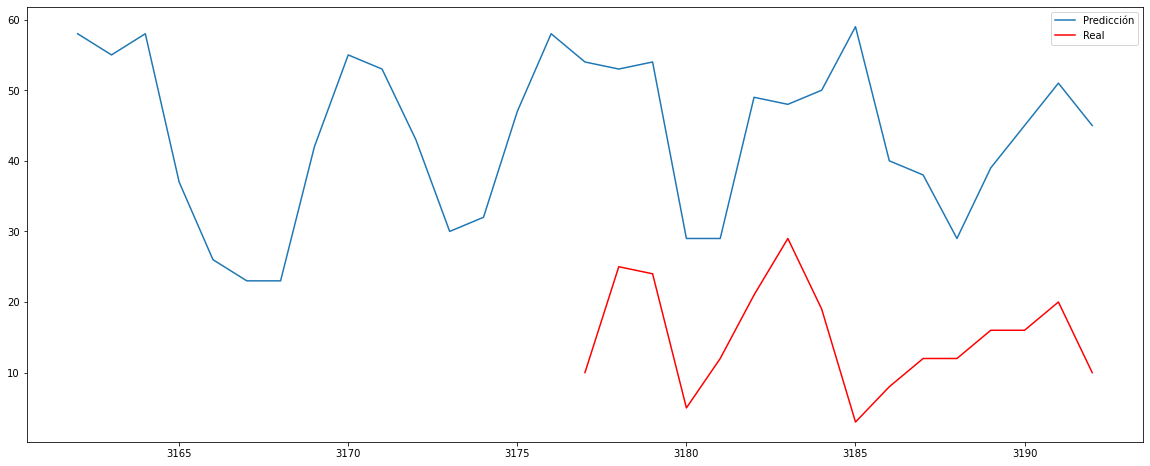

In [22]:
dataEstacion = dataComparada[dataComparada['ESTACION']==106]
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))
plt.plot(dataEstacion['PREDICCION'], label='Predicción')
plt.plot(dataEstacion['DEMANDA'], color='red', label='Real')
plt.legend()